# Financial Econometrics: Homework 1
#### Kryštof Veřtát, Tomáš Svoboda

# Problem 1

We begin with loading the stock symbols file and preparing the list of all available IT symbols for a download. 

In [2]:
library(quantmod)
library(dplyr)
library(StableEstim)
library(stabledist)

In [3]:
set.seed(5)

In [4]:
# Import file with stock symbols
indices <- read.csv("symbols.csv", header = TRUE, sep=";")
head(indices)

,Symbol,Name,Sector
,<chr>,<chr>,<chr>
1,MMM,3M Co.,Industrials
2,ACE,ACE Limited,Financials
3,ABT,Abbott Laboratories,Health Care
4,ANF,Abercrombie & Fitch Company A,Consumer Discretionary
5,ACN,Accenture,Information Technology
6,ADBE,Adobe Systems Inc,Information Technology


In [6]:
# Overview of the industry categories
indices$Sector <- as.factor(indices$Sector)
summary(indices)
unique(indices$Sector)

    Symbol              Name                              Sector   
 Length:500         Length:500         Consumer Discretionary: 83  
 Class :character   Class :character   Financials            : 82  
 Mode  :character   Mode  :character   Information Technology: 69  
                                       Industrials           : 61  
                                       Health Care           : 52  
                                       Energy                : 43  
                                       (Other)               :110  

[1] Industrials                 Financials                 
 [3] Health Care                 Consumer Discretionary     
 [5] Information Technology      Utilities                  
 [7] Materials                   Energy                     
 [9] Consumer Staples            Telecommunications Services
10 Levels: Consumer Discretionary Consumer Staples Energy ... Utilities

In [7]:
# Select the IT industry symbols
IT <- indices[indices$Sector == "Information Technology",]
head(IT)
count <- nrow(IT)
print(paste("Number of companies in IT index:", count))

,Symbol,Name,Sector
,<chr>,<chr>,<fct>
5,ACN,Accenture,Information Technology
6,ADBE,Adobe Systems Inc,Information Technology
7,AMD,Advanced Micro Devices,Information Technology
15,AKAM,Akamai Technologies Inc,Information Technology
22,ALTR,Altera Corp,Information Technology
35,ADI,Analog Devices Inc,Information Technology


[1] "Number of companies in IT index: 69"


In [8]:
# Stocks not included in quantmod package
excluded_stocks <- c("BRCM", "CTXS", "FISV", "FLIR", "HRS", 
                    "JDSU", "LXK", "LLTC", "LSI", "MOLX", 
                    "RHT", "SNDK", "SYMC", "TSS", "XLNX", "YHOO")
symbols <- c(IT$Symbol[!IT$Symbol %in% excluded_stocks])
symbols


[1] "ACN"  "ADBE" "AMD"  "AKAM" "ALTR" "ADI"  "AAPL" "AMAT" "ADSK" "ADP" 
[11] "BMC"  "CA"   "CSCO" "CTSH" "CSC"  "DELL" "EBAY" "EA"   "EMC"  "FFIV"
[21] "FIS"  "GOOG" "HPQ"  "INTC" "IBM"  "INTU" "JBL"  "JNPR" "KLAC" "LRCX"
[31] "MA"   "MCHP" "MU"   "MSFT" "MSI"  "NTAP" "NFLX" "NVDA" "ORCL" "PAYX"
[41] "QCOM" "SAI"  "CRM"  "STX"  "TEL"  "TDC"  "TER"  "TXN"  "VRSN" "V"   
[51] "WDC"  "WU"   "XRX"

Data for the selected IT companies are downloaded from Yahoo database.

In [9]:
# Download the data from Yahoo database
mydata <- lapply(symbols, function(y){
    getSymbols(y, src="yahoo", from="2015-07-01", to="2023-12-31",
            auto.assign=FALSE)
})

Warning message:
"BMC contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."
Warning message:
"CSC contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


In [10]:
# Add names of the stocks
names(mydata) <- symbols

In [11]:
# Check the data and count how many IT companies were downloaded
lapply(mydata, head)
print(paste("Number of IT companies downloaded:",length(mydata), "out of", count))

$ACN
           ACN.Open ACN.High ACN.Low ACN.Close ACN.Volume ACN.Adjusted
2015-07-01    97.74    98.79   97.31     98.06    2259500     85.05795
2015-07-02    98.29    98.72   96.51     97.33    2456700     84.42477
2015-07-06    96.44    97.58   96.31     97.34    1817900     84.43343
2015-07-07    97.80    99.10   96.65     98.68    3089500     85.59576
2015-07-08    99.45    99.45   96.95     97.62    2623300     84.67632
2015-07-09    98.80    99.09   97.65     97.75    2734900     84.78907

$ADBE
           ADBE.Open ADBE.High ADBE.Low ADBE.Close ADBE.Volume ADBE.Adjusted
2015-07-01     81.57     81.92    80.71      80.94     2944300         80.94
2015-07-02     81.19     81.29    80.38      80.75     2200900         80.75
2015-07-06     80.02     81.19    80.00      80.50     2590900         80.50
2015-07-07     80.77     81.00    78.94      80.59     2781900         80.59
2015-07-08     79.95     80.52    79.40      79.99     4157600         79.99
2015-07-09     80.74     81.6

[1] "Number of IT companies downloaded: 53 out of 69"


We select only the 'Close' price for further calculations.

In [12]:
# Select the 'Close' prices
data <- lapply(mydata, function(y){
  y <- y[ ,4]
})

In [13]:
# Check the data
head(data$AAPL)

           AAPL.Close
2015-07-01    31.6500
2015-07-02    31.6100
2015-07-06    31.5000
2015-07-07    31.4225
2015-07-08    30.6425
2015-07-09    30.0175

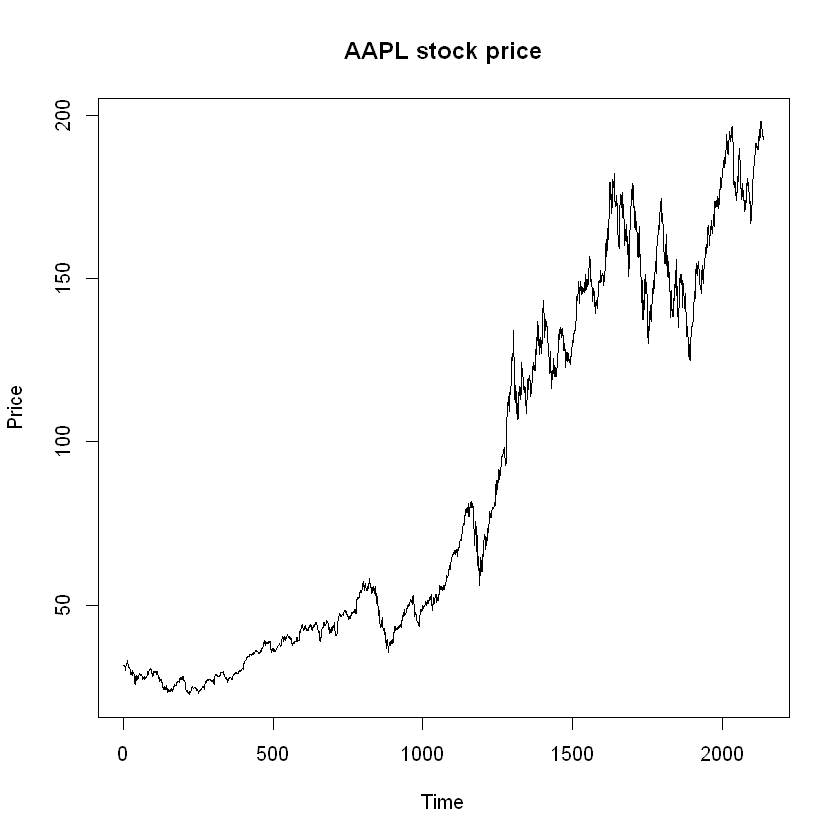

In [14]:
# Check the data plot
plot.ts(data$AAPL, main="AAPL stock price", ylab="Price")

The stock data are downloaded and transformed as needed for further analysis.

1. Compute the log-returns and simple returns for all the stocks. Save these to lrets and rets objects respectively. From now on, you will work with the logarithmic returns.

In [15]:
# Simple returns
rets <- lapply(data, function(y){
    na.omit(diff(y))
})

In [16]:
# Log returns
lrets <- lapply(data, function(y){
    na.omit(diff(log(y)))
})

Both simple and logarithmic returns are calculated according to the formula as a (logarihm) change of price between adjacents time periods.

In [17]:
# Check the data
lapply(lrets, head)

$ACN
               ACN.Close
2015-07-02 -0.0074722261
2015-07-06  0.0001026815
2015-07-07  0.0136723280
2015-07-08 -0.0107998762
2015-07-09  0.0013307803
2015-07-10  0.0104819439

$ADBE
             ADBE.Close
2015-07-02 -0.002350208
2015-07-06 -0.003100778
2015-07-07  0.001117342
2015-07-08 -0.007472927
2015-07-09  0.005982859
2015-07-10  0.001490068

$AMD
             AMD.Close
2015-07-02  0.04445172
2015-07-06 -0.02400113
2015-07-07 -0.16705414
2015-07-08 -0.03902931
2015-07-09 -0.01503786
2015-07-10 -0.01015236

$AKAM
             AKAM.Close
2015-07-02 -0.006558322
2015-07-06 -0.002147943
2015-07-07  0.005004636
2015-07-08 -0.017989979
2015-07-09  0.006369483
2015-07-10  0.009764585

$ALTR
            ALTR.Close
2017-11-02 -0.05040258
2017-11-03  0.10668078
2017-11-06 -0.02086677
2017-11-07  0.02806842
2017-11-08  0.04264506
2017-11-09  0.00196266

$ADI
              ADI.Close
2015-07-02 -0.002946919
2015-07-06 -0.012346756
2015-07-07 -0.003307857
2015-07-08 -0.022982219
2015-07-0

2. Compute the sample mean, variance, skewness, excess kurtosis, minimum and maximum of the series of logarithmic returns for each of the stocks in your sample. Display these in a nicely readable manner.

In [18]:
# Descriptive statistics calculation
stats <- lapply(lrets, function(y){
    c(mean(y), 
    var(y), 
    mean((y - mean(y))^3) / (sqrt(var(y))^3),
    mean((y - mean(y))^4) / (var(y)^2), 
    min(y), 
    max(y))
})

In [20]:
# Round the statistics for better readability
stats <- sapply(stats, function(y){
    round(y, 4)
})

In [21]:
# Add the names and build a table
rownames(stats) <- c("mean", "var", "skewness", "kurtosis", "min", "max")
colnames(stats) <- symbols
t(stats)

,mean,var,skewness,kurtosis,min,max
ACN,0.0006,0.0003,-0.0191,9.1447,-0.0876,0.1210
ADBE,0.0009,0.0004,-0.5564,11.7033,-0.1838,0.1631
AMD,0.0019,0.0014,0.5343,13.5340,-0.2775,0.4206
AKAM,0.0002,0.0004,-0.6234,21.2387,-0.1831,0.1923
ALTR,0.0010,0.0007,-0.9309,12.5693,-0.2223,0.1669
ADI,0.0005,0.0004,-0.3477,10.7263,-0.1817,0.1371
AAPL,0.0008,0.0003,-0.2332,8.4058,-0.1377,0.1132
AMAT,0.0010,0.0007,-0.4177,8.3602,-0.2276,0.1294
ADSK,0.0007,0.0006,-0.2461,10.3341,-0.1727,0.1501
ADP,0.0005,0.0003,-0.8010,16.8387,-0.1655,0.1116


3. Try to devise one Figure that plots all time series of returns in your sample.

In [22]:
# Function to plot the returns
returns_plot <- function(stocks) {
   amount <- length(stocks)
   par(mfrow = c(ceiling(amount/3), 3))

   for (i in 1:amount) {
      name <- names(stocks)[i]
      returns <- stocks[[i]]
      plot(index(returns), returns, type="l", ylab="Returns", xlab="Year", main=name)
   }
}

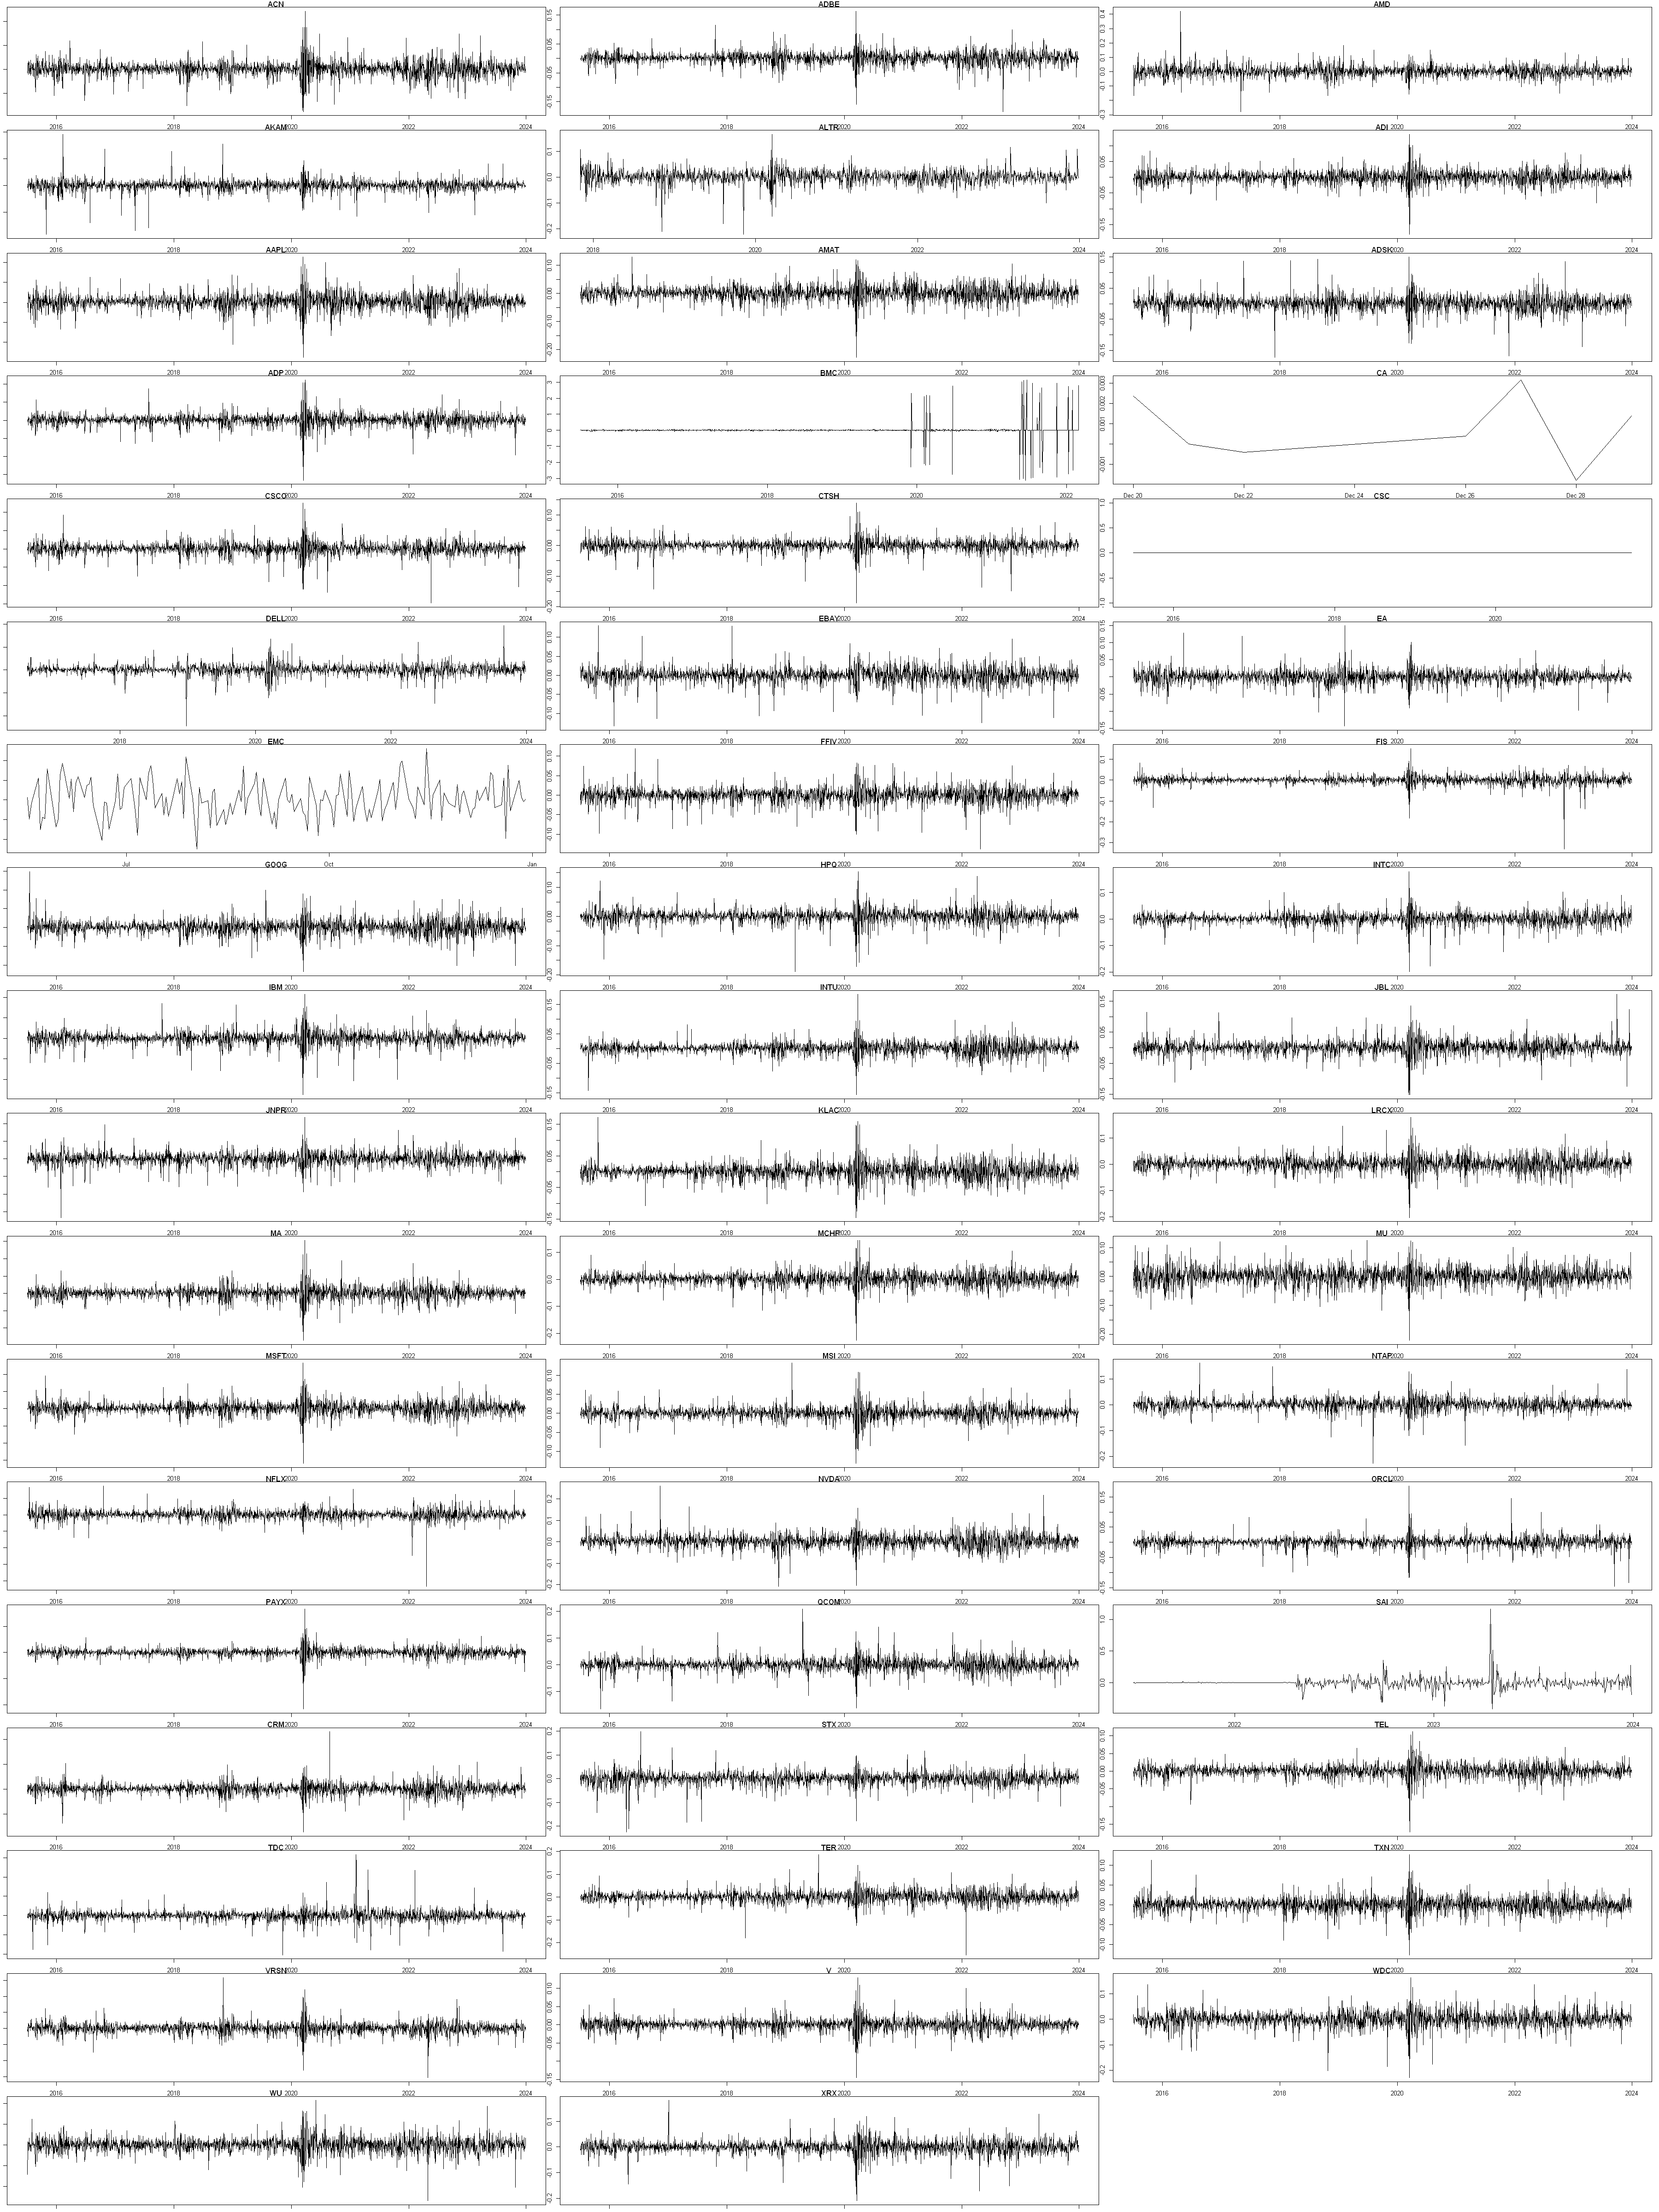

In [23]:
# Set the parameters and plot the returns 
par(mar = c(1, 1, 1, 1),mfrow = c(1,3))
options(repr.plot.width=30, repr.plot.height=40)
returns_plot(lrets)

The stocks containing lots of NAs are clearly visible and it is also intresting to see the largest returns around year 2020 suggesting the beggining of Covid crisis and alligned overall market price changes.  

4. Discard the symbols, where you don't have valid data (non-missing, non-NA) for at least 80% of the dates in the sample period (use the stocks with the most observations as the benchmark for the sample period). For each symbol in your dataset, keep only the dates where you have valid data for all of the remaining symbols, i.e. you will have N time-series with matching timestamps. Now compute the mean logarithmic return for each date. The result should be a time-series with one (mean) log-return for each date.

Incomplete stocks are removed from the data.

In [24]:
# Maximum complete days as a benchmark
num_rows <- sapply(lrets, nrow)
max_rows <- max(num_rows)
print(paste("Maximum reported days:", max_rows))

[1] "Maximum reported days: 2139"


In [25]:
# Filter the stocks with at least 80% of the maximum reported days
lrets_clean <- lrets[num_rows >= 0.8*max_rows]

max_rows_clean <- length(lrets_clean)
print(paste("Number of initial IT stocks with at least 80% of the maximum reported days:", max_rows_clean, "out of", count, "IT firms"))

[1] "Number of initial IT stocks with at least 80% of the maximum reported days: 47 out of 69 IT firms"


In [26]:
# Find intersection of all stocks dates
dates <- index(lrets_clean[[1]]) # 1. stock dates

# Loop over remaining stocks and keep only dates that intersect with the previous stocks dates
for (i in 2:length(lrets_clean)) {
    dates <- index(lrets_clean[[i]])[index(lrets_clean[[i]]) %in% dates]
}

length(dates) # Number of complete dates common for all stocks 

[1] 1854

In [27]:
# Filter the stocks with the common dates
lrets_clean <- lapply(lrets_clean, function(y) {
    y[index(y) %in% dates]
})

In [29]:
# Check randomly match of time stamps
all(index(lrets_clean[[sample(1:47,1)]]) == index(lrets_clean[[sample(1:47,1)]]))

[1] TRUE

The mean logarithmic return for each date is calculated.

In [30]:
# Mean daily returns
daily_returns <- c()
for (i in 1:length(dates)){
    mean = mean(sapply(lrets_clean, '[[', i))
    daily_returns <- cbind(daily_returns, mean)
} 

daily_returns <- as.data.frame(t(daily_returns))
rownames(daily_returns) <- dates

head(daily_returns)

,V1
,<dbl>
2016-08-18,0.007950616
2016-08-19,0.008687119
2016-08-22,-0.001028408
2016-08-23,0.005836718
2016-08-24,-0.007446050
2016-08-25,0.004357307


5. Estimate the parameters of the stable distribution for the mean returns computed in 4. Please, comment.

In [32]:
# Adjust data format
daily_returns <- as.numeric(as.matrix(daily_returns))

In [33]:
# Estimate the stable distribution parameters
stable_dist <- Estim(EstimMethod = "Kout", 
                    data = daily_returns,
                    pm = 0,
                    ComputeCov = FALSE,
                    HandleError = FALSE,
                    spacing = "Kout")

stable_dist

*** Class Estim, method Show *** 
** Method ** 
[1] "Koutrouvelis_spacing=Kout"
** Parameters Estimation ** 
       alpha         beta        gamma        delta 
 1.617749339 -0.347270282  0.007542739  0.001735536 
** Covariance Matrix Estimation ** 
     [,1] [,2] [,3] [,4]
[1,]   NA   NA   NA   NA
[2,]   NA   NA   NA   NA
[3,]   NA   NA   NA   NA
[4,]   NA   NA   NA   NA
** Confidence interval Estimation ** 
[1] "Confidence level= 0"
[1] "data length= 1854"
     [,1] [,2]
[1,]   NA   NA
[2,]   NA   NA
[3,]   NA   NA
[4,]   NA   NA
attr(,"level")
[1] 0
** Estimation time ** 
[1] " :duration= 0  h, 0  min, 5  sec. "
** Estimation status ** 
success
 ******* End Show (Estim) ******* 

In [34]:
# Parameters overview
alpha = stable_dist@par[1]
round(alpha,6)
beta = stable_dist@par[2]
round(beta,6)
c = stable_dist@par[3]
round(c,6)
mu = stable_dist@par[4]
round(mu, 6)

alpha 
1.617749

beta 
-0.34727

gamma 
0.007543

delta 
0.001736

Size of the alpha parameter being close to 2 on a scale (0,2] suggest a little bit of proximity to the normal distribution. The beta parameter being relatively large and negative from the scale (-1,1) imdicates some skewness in our data. Finally, the c and $\mu$ parameters affecting the scale and location, respectively, do not show any significant assymetry in the data.  

6. Plot the histogram of the mean returns and compare to the densities of normal distribution, and stable distribution with the tted parameters from the previous step. Please, comment.

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""legend" is not a graphical parameter"


Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""legend" is not a graphical parameter"


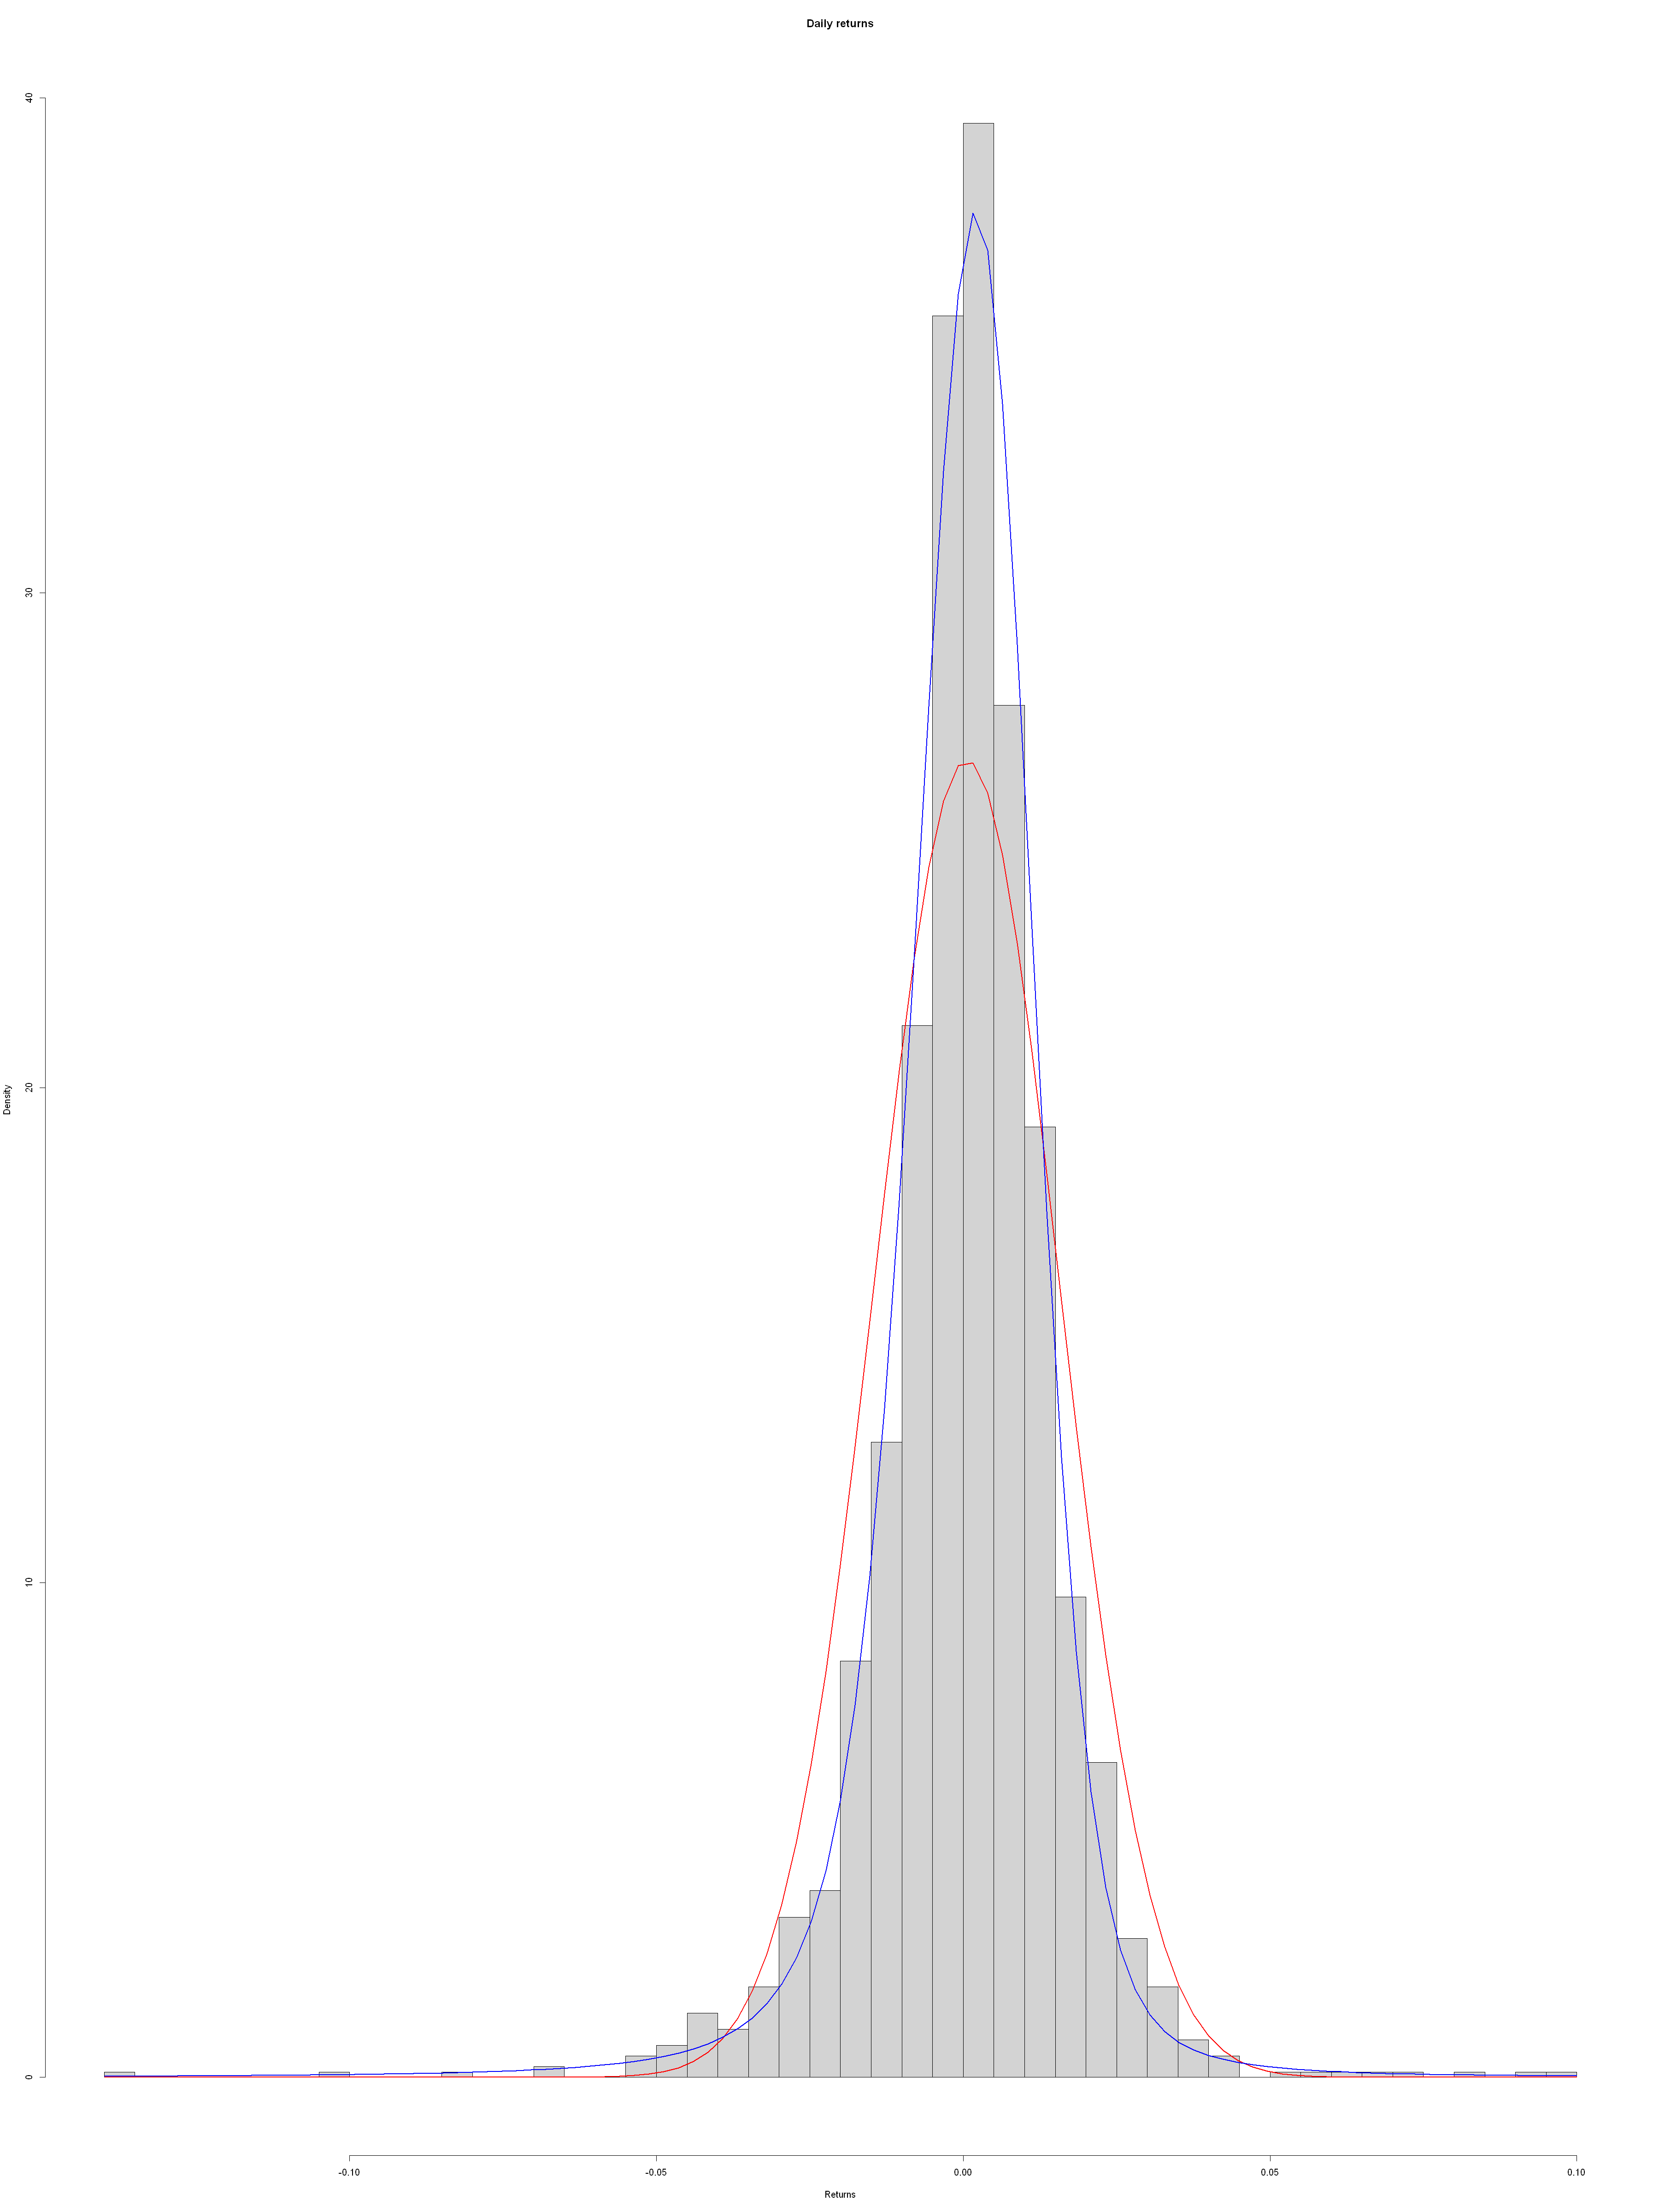

In [35]:
# Histogram or daily mean returns
hist(daily_returns, breaks=50, freq=FALSE, main="Daily returns", xlab="Returns")

# Normal distribution
curve(dnorm(x, mean=mean(daily_returns), sd=sd(daily_returns)), col="red", lwd=2, add=TRUE, legend="Normal")

# Stable distribution
curve(dstable(x, 
        alpha=stable_dist@par[1], 
        beta=stable_dist@par[2], 
        gamma=stable_dist@par[3],
        delta=stable_dist@par[4]),
        col="blue", lwd=2, add=TRUE, legend="Stable")

The resulting histogram nicely shows that our data do not really belong to the normal distribution as often assumed. Instead, the Levy-stable distribution estimated based on our data replicates the distribution more accurately and should be used for further implications.     

# Problem 2

### Part 1

#### Process 1
Expected value of $p_t$ is equal to sum of expected values of components of $p_t$.
$$E(p_t) = E(\mu + p_{t-1} + \epsilon_{t} + \epsilon_{t-1}) 
=  E(\mu) + E(p_{t-1}) + E(\epsilon_{t}) + E(\epsilon_{t-1}) $$
 
Because it is constant, expected value of $\mu$ is equal to its value.
$$E(\mu) = \mu$$

$\epsilon_t$ and $\epsilon_{t-1}$ have normal distribution with mean equal to 0 and are independent of each other. Therefore, their expected value is 0 and can be removed from the expression.

$$E(p_t) = \mu + E(p_{t-1})$$

$p_{t-1}$ can be rewritten as sum of its components.
$$p_{t-1} = \mu + p_{t-2} + \epsilon_{t-1} + \epsilon_{t-2}$$

So we can rewrite the expected value of $p_t$ as:
$$E(p_t) = \mu + \mu + p_{t-2} + \epsilon_{t-1} + \epsilon_{t-2}$$

Again, epsilons have expected value of of zero and $p_{t-2}$ can be rewritten as we showed for for $p_{t-1}$. That continues consecutively.
So, the expected value is equal to the number of $\mu$ times number of observations. 
$$ E(p_t) = t * \mu$$

For $E(p_200)$ we have to include $p_0$.
$$E(p_{200}) = p_0 + t * \mu  = 15 + 200 * 0.2 = 55 $$

The first process is not mean stationary, because the mean is not constant and is dependent on $t$.

Variance of $p_t$ depends on variance of $p_{t-1}$ and variances of $\epsilon_t$ and $epsilon_{t-1}$ 

$$Var(p_t) = Var(p_{t-1}) + \sigma_{\epsilon_t}^2 + 2*\sigma_{\epsilon_t}*\sigma_{\epsilon_{t-1}} + \sigma_{\epsilon_{t-1}}^2$$

Breaking down $ Var(p_{t-1})$,  $Var(p_{t-2})$,... results in the following formula:
$$Var(p_t) = t * (\sigma_{\epsilon_t}^2 + 2*\sigma_{\epsilon_t}*\sigma_{\epsilon_{t-1}} + \sigma_{\epsilon_{t-1}}^2)$$
$$Var(p_{200}) = 200 * (4^2 + 2*4*4 + 4^2) = 12800 $$

Variance is increasing with $t$, so the process is not variance stationary.

#### Process 2
The expected value of $r_t$ is equal to sum of the expected values. $\epsilon_t$ can be rewritten.
$$E(r_t) = E(r_{t-1} + \epsilon_t) = E(r_{t-1}) + E(\epsilon_t)  = E(r_{t-1}) - E(\epsilon_{t-1}) +  E(\eta_t)$$ 

Expected value of $\eta_t$ is 0. Moreover, we can break down $r_{t-1}.$
$$r_{t-1} = r_{t-2} + \epsilon_{t-1} $$
$$E(r_t) = E(r_{t-2}) + E(\epsilon_{t-1}) -  E(\epsilon_{t-1}) $$

We can continue in the similar breaking down $r_{t-2}$ and $\epsilon$ is always canceled out. So, the expected value of $r_t$ depends only on its initial value.
$$E(r_t) = r_0$$

For $r_{400}$ expected value is following:
$$E(r_{400}) = r_0 = 15$$

The second process is mean stationary, because the mean is constant.

### Part 2

As the $\epsilon_{t}$ is independently and identically distributed, the covariance is zero.
$$Cov(\epsilon_{t}, \epsilon_{t-1}) = 0$$

For the second process it is not so simple. We have to break down $\epsilon_t$ according to the equation $\epsilon_t = -\epsilon_{t-1} + \eta_{t}$.
$$Cov(\epsilon_{t}, \epsilon_{t-1}) = Cov(-\epsilon_{t-1} + \eta_t, \epsilon_{t-1}) = 
Cov(-\epsilon_{t-1}, \epsilon_{t-1}) + Cov(\epsilon_{t-1}, \eta_t) = - Cov(\epsilon_{t-}, \epsilon_{t-1})+ Cov(\epsilon_{t-1}, \eta_t) = -1 + 0  = -1$$    



### Part 3

#### Process 1

In [1]:
# # Simulate 1 realization of the process
T <- 500
e <- rnorm(T,0,4)
m <- 0.2
p0 <- 15
e0 <- 0
pt <- vector()
pt[1] <- m + p0 + e[1] + e0
for(t in 2:T){
    pt[t] <- m + pt[t-1] + e[t] + e[t-1]
}

In [2]:
# Simulate 1000 realizations of the process
pt1000 <- matrix(ncol = 1000, nrow = T)
for (j in 1 : ncol(pt1000)){
  e <- rnorm(T,0,4)
  pt1000[1, j] <- m + p0 + e[1] + e0
  for (t in 2 : T){
    pt1000[t, j] <- m + pt1000[t-1, j] + e[t] + e[t-1]
}}

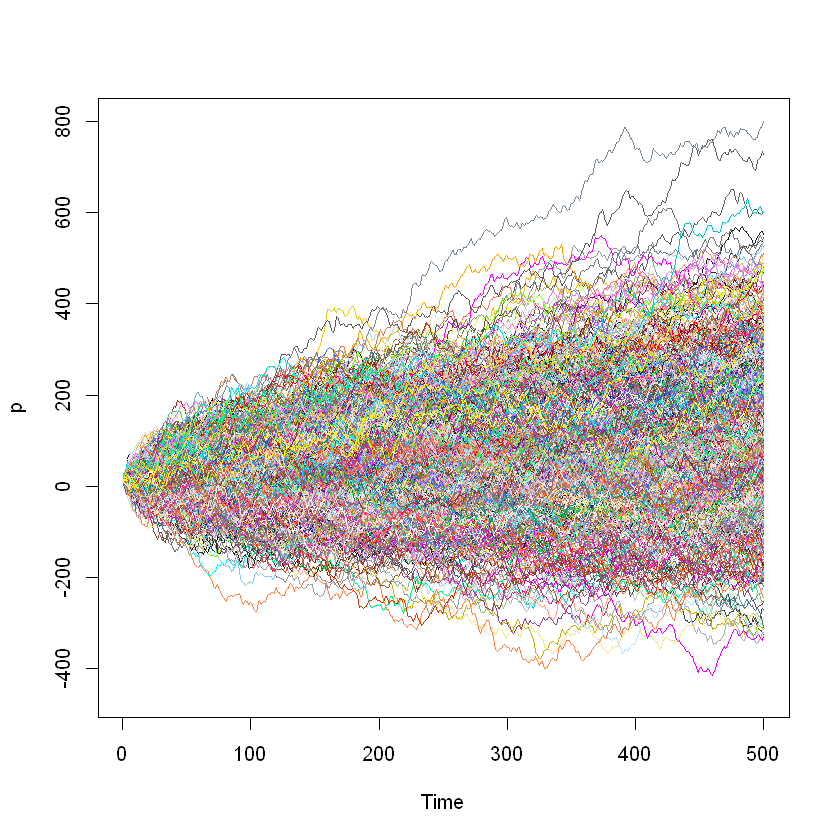

In [3]:
# Plot all the realizations
plot.ts(pt1000[, 1], ylim = c(min(pt1000),max(pt1000)), ylab = 'p')
for (j in 1:ncol(pt1000)){
   lines(pt1000[, j], col = colors()[j])
}



#### Process 2

In [4]:
# # Simulate 1 realization of the process
eta <- rnorm(T,0,1)
eps0 <- 0
eps <- vector()
eps[1] <- -eps0 + eta[1]
for(t in 2:T){
    eps[t] <- -eps[t-1] + eta[t]
}
r0 <- 15
rt <- vector()
rt[1] <- r0 + eps[1]
for(t in 2:T){
    rt[t] <- rt[t-1] + eps[t]
}

In [5]:
# Simulate 1000 realizations of the process
rt1000 <- matrix(ncol = 10000, nrow = T)
for (j in 1 : ncol(rt1000)){
  eta <- rnorm(T,0,1)
  eps[1] <- -eps0 + eta[1]
    
  for(t in 2:T){
  eps[t] <- -eps[t-1] + eta[t]
    }
    
  rt1000[1, j] <- r0 + eps[1]
  for (t in 2 : T){
    rt1000[t, j] <- rt1000[t-1, j] + eps[t]
}}

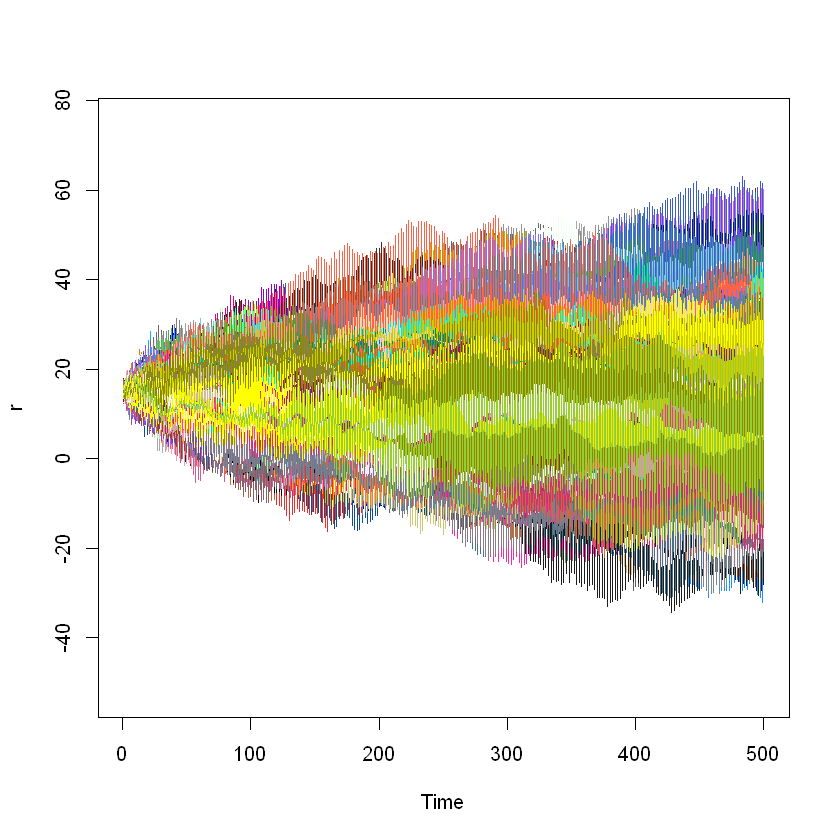

In [6]:
# Plot all the realizations
plot.ts(rt1000[, 1], ylim = c(min(rt1000),max(rt1000)), ylab = 'r')
for (j in 1:ncol(rt1000)){
   lines(rt1000[, j], col = colors()[j])
}



From charts, we can see that the first process has slightly increasing mean and the second process is mean stationary. Both processes have increasing variance.